Device: GPU


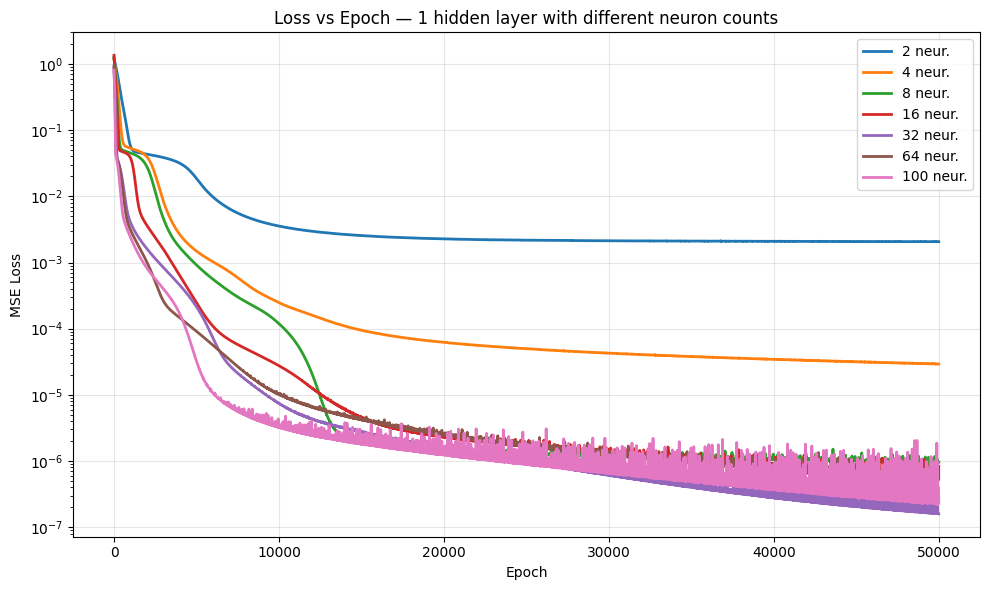


Final Loss (last epoch) — 1 hidden layer:
    Neuronen |   Final Loss
---------------------------
           2 |    2.066e-03
           4 |    2.923e-05
           8 |    9.623e-07
          16 |    8.284e-07
          32 |    1.594e-07
          64 |    5.318e-07
         100 |    2.799e-07


In [11]:
from tinygrad import Tensor, Device
from tinygrad.nn.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

print("Device:", Device.DEFAULT)
Tensor.training = True  # notwendig für Optimizer.step()

# -----------------------
# Data
# -----------------------
n = 1000          
epochs = 50000
batch_size = 1000

np.random.seed(0)
X_np = np.random.uniform(-1, 1, (n, 2)).astype(np.float32)
q1, q2 = X_np[:, 0], X_np[:, 1]
Y_np = np.stack([q1 + q2 - 1.0, q1 - q2**2 + 1.0], axis=1).astype(np.float32)

# -----------------------
# Model (variabel)
# -----------------------
class MLP:
    def __init__(self, hidden_layers: int, hidden_dim: int):
        assert hidden_layers >= 1
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim

        def w(in_dim, out_dim):
            # scaled init for tanh
            return Tensor.randn(in_dim, out_dim, requires_grad=True) * np.sqrt(1.0 / in_dim)

        self.weights = []
        self.biases = []

        # input -> first hidden
        self.weights.append(w(2, hidden_dim))
        self.biases.append(Tensor.zeros(hidden_dim, requires_grad=True))

        # hidden -> hidden
        for _ in range(hidden_layers - 1):
            self.weights.append(w(hidden_dim, hidden_dim))
            self.biases.append(Tensor.zeros(hidden_dim, requires_grad=True))

        # last hidden -> output (2)
        self.w_out = w(hidden_dim, 2)
        self.b_out = Tensor.zeros(2, requires_grad=True)

    def parameters(self):
        return self.weights + self.biases + [self.w_out, self.b_out]

    def __call__(self, x: Tensor):
        for W, b in zip(self.weights, self.biases):
            x = (x @ W + b).tanh()
        x = (x @ self.w_out + self.b_out)  # linear output
        return x

# -----------------------
# Training helper
# -----------------------
def train_one(hidden_layers: int, hidden_dim: int, seed: int = 0):
    np.random.seed(seed)

    model = MLP(hidden_layers, hidden_dim)
    opt = Adam(model.parameters(), lr=1e-3)

    loss_history = []
    for epoch in range(epochs):
        perm = np.random.permutation(n)
        epoch_loss = 0.0
        nb = 0

        for start in range(0, n, batch_size):
            idx = perm[start:start+batch_size]
            xb = Tensor(X_np[idx], device=Device.DEFAULT)
            yb = Tensor(Y_np[idx], device=Device.DEFAULT)

            pred = model(xb)
            loss = ((pred - yb) ** 2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
            nb += 1

        epoch_loss /= nb
        loss_history.append(epoch_loss)

    return model, loss_history

# -----------------------
# Sweep + Plots (1 hidden layer with different neuron counts)
# -----------------------
neuron_list = [2, 4, 8, 16, 32, 64, 100]    # different neuron counts

final_losses = {}  # (N) -> final loss
trained_models = {}  # (N) -> trained model

plt.figure(figsize=(10, 6))
for N in neuron_list:
    model, lh = train_one(1, N, seed=42)  # 1 hidden layer, N neurons
    final_losses[N] = lh[-1]
    trained_models[N] = model
    plt.plot(lh, label=f"{N} neur.", linewidth=2)

plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss vs Epoch — 1 hidden layer with different neuron counts")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------
# Result Table (Final Loss)
# -----------------------
print("\nFinal Loss (last epoch) — 1 hidden layer:")
print(f"{'Neuronen':>12} | {'Final Loss':>12}")
print("-" * 27)
for N in neuron_list:
    print(f"{N:>12d} | {final_losses[N]:>12.3e}")
